# K Means Clustering for Imagery Analysis
### Presented by Eduonix!

In this project, we will use a K-means algorithm to perform image classification.  Clustering isn't limited to the consumer information and population sciences, it can be used for imagery analysis as well. Leveraging Scikit-learn and the MNIST dataset, we will investigate the use of K-means clustering for computer vision.

In this project, we will learn how to:

* Preprocess images for clustering
* Deploy K-means clustering algorithms
* Use common metrics to evaluate cluster performance
* Visualize high-dimensional cluster centroids

Let's get started by importing a few of the libraries we will use in this project.

In [1]:
import sys
import sklearn
import matplotlib
import numpy as np

print('Python: {}'.format(sys.version))
print('Sklearn: {}'.format(sklearn.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('NumPy: {}'.format(np.__version__))

Python: 3.7.7 (default, Mar 23 2020, 23:19:08) [MSC v.1916 64 bit (AMD64)]
Sklearn: 1.0.2
Matplotlib: 3.5.1
NumPy: 1.21.5


### 1. Import the MNIST dataset


In [4]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Training Data: {}'.format(x_train.shape))
print('Training Labels: {}'.format(y_train.shape))
print('Testing Data: {}'.format(x_test.shape))
print('Testing Labels: {}'.format(y_test.shape))

Training Data: (60000, 28, 28)
Training Labels: (60000,)
Testing Data: (10000, 28, 28)
Testing Labels: (10000,)


e:\environment\anaconda3\envs\torch1.7.1\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


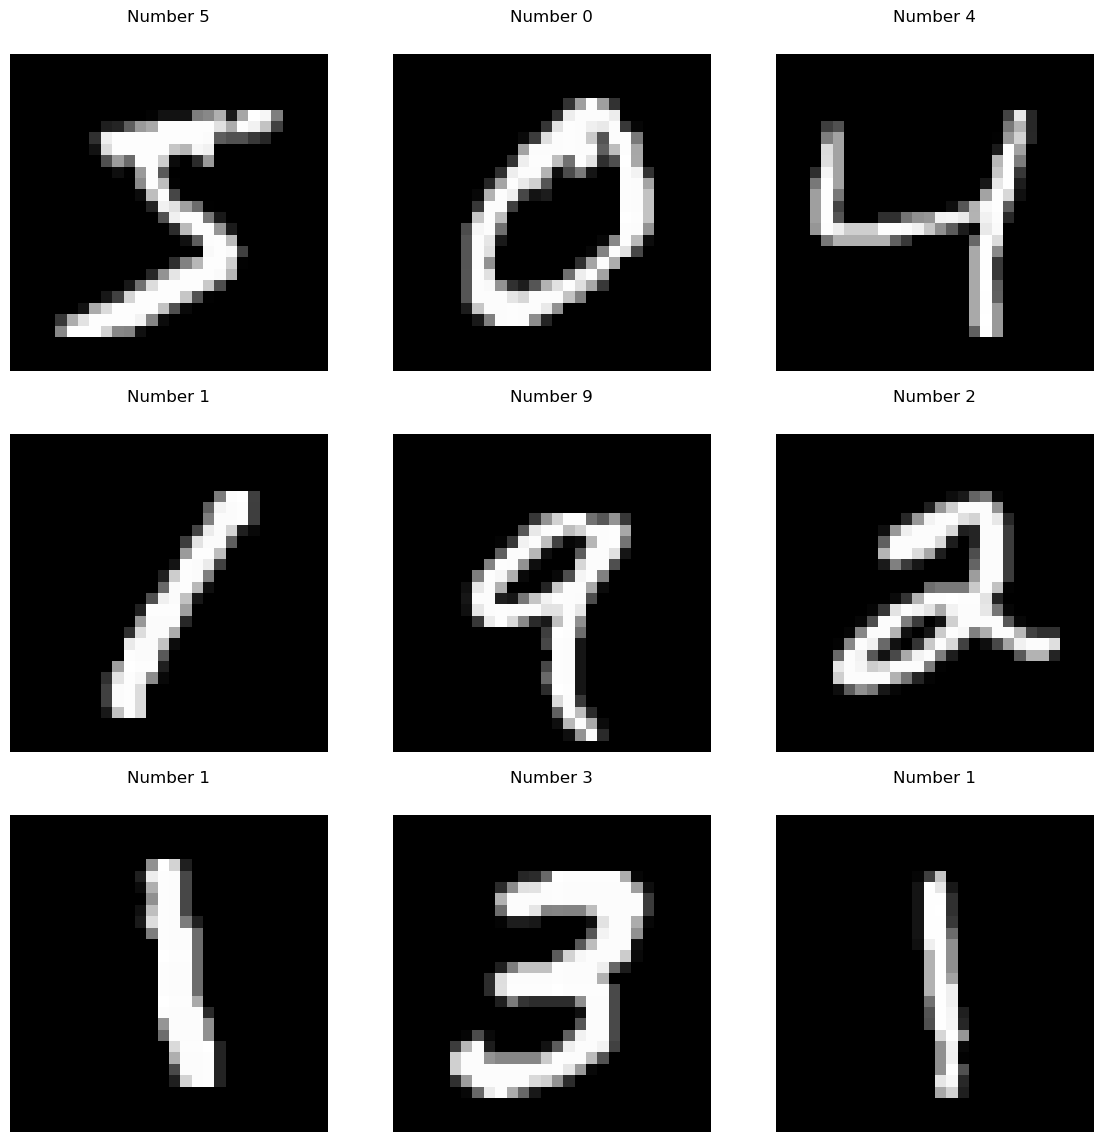

In [22]:
import matplotlib.pyplot as plt

# python magic function
%matplotlib inline

# create figure with 3x3 subplots using matplotlib.pyplot
fig, axs = plt.subplots(3, 3, figsize = (14,14))
plt.gray()# set the color map to grayscale

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.matshow(x_train[i])
    ax.axis('off')
    ax.set_title('Number {}'.format(y_train[i]))
    
# display the figure
fig.show()

### 2. Preprocessing the MNIST images

Images stored as NumPy arrays are 2-dimensional arrays.  However, the K-means clustering algorithm provided by scikit-learn ingests 1-dimensional arrays; as a result, we will need to reshape each image.  

MNIST contains images that are 28 by 28 pixels; as a result, they will have a length of 784 once we reshape them into a 1-dimensional array.  

In [25]:
# preprocessing the images

# convert each image to 1 dimensional array
X = x_train.reshape(len(x_train),-1)
Y = y_train

# normalize the data to 0 - 1
X = X.astype(float) / 255.

print(X.shape)
print(X[0].shape)

(60000, 784)
(784,)


### 3. K-Means Clustering

The MNIST dataset contains images of the integers 0 to 9.  Because of this, let's start by setting the number of clusters to 10, one for each digit. 

In [57]:
from sklearn.cluster import MiniBatchKMeans

n_digits = len(np.unique(y_test))
print(n_digits)

# Initialize KMeans model
kmeans = MiniBatchKMeans(n_clusters = n_digits)

# Fit the model to the training data
kmeans.fit(X)

10


e:\environment\anaconda3\envs\torch1.7.1\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  "MiniBatchKMeans is known to have a memory leak on "


MiniBatchKMeans(n_clusters=10)

In [58]:
kmeans.labels_# array of labels for each data point

array([5, 7, 8, ..., 5, 1, 9])

### 4. Assigning Cluster Labels

K-means clustering is an unsupervised machine learning method; consequently, the labels assigned by our KMeans algorithm refer to the cluster each array was assigned to, not the actual target integer.  To fix this, let's define a few functions that will predict which integer corresponds to each cluster.  

In [59]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}
    #kemeans.labels_ is an array of labels for each data point
    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        # returns a tuple of arrays, one for each dimension of a, containing the indices of the non-zero elements in that dimension.
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))# the number of occurrences of each value in an arrays.

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [60]:
# test the infer_cluster_labels() and infer_data_labels() functions,
# covert the cluster labels to real labels
cluster_labels = infer_cluster_labels(kmeans, Y) # dictionary of {real label: [cluster numbers]}
X_clusters = kmeans.predict(X)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print(predicted_labels[:20])
print(Y[:20])

[3 0 6 1 4 2 1 2 1 7 3 1 3 6 1 7 2 7 6 7]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


: 

### 5. Optimizing and Evaluating the Clustering Algorithm

With the functions defined above, we can now determine the accuracy of our algorithms.  Since we are using this clustering algorithm for classification, accuracy is ultimately the most important metric; however, there are other metrics out there that can be applied directly to the clusters themselves, regardless of the associated labels. Two of these metrics that we will use are inertia and homogeneity. 

Furthermore, earlier we made the assumption that K = 10 was the appropriate number of clusters; however, this might not be the case.  Let's fit the K-means clustering algorithm with several different values of K, than evaluate the performance using our metrics. 

In [49]:
from sklearn import metrics

def calculate_metrics(estimator, data, labels):

    # Calculate and print metrics
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))

In [54]:
clusters = [10, 16, 36, 64, 144, 256]

# test different numbers of clusters
for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters = n_clusters)
    estimator.fit(X)
    
    # print cluster metrics
    calculate_metrics(estimator, X, Y)
    
    # determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, Y)
    predicted_Y = infer_data_labels(estimator.labels_, cluster_labels)
    
    # calculate and print accuracy
    print('Accuracy: {}\n'.format(metrics.accuracy_score(Y, predicted_Y)))

e:\environment\anaconda3\envs\torch1.7.1\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  "MiniBatchKMeans is known to have a memory leak on "


Number of Clusters: 10
Inertia: 2372569.5952367047
Homogeneity: 0.42815881540227213
Accuracy: 0.5133166666666666



e:\environment\anaconda3\envs\torch1.7.1\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  "MiniBatchKMeans is known to have a memory leak on "


Number of Clusters: 16
Inertia: 2220922.1397017683
Homogeneity: 0.5542689950058788
Accuracy: 0.6514



e:\environment\anaconda3\envs\torch1.7.1\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  "MiniBatchKMeans is known to have a memory leak on "


Number of Clusters: 36
Inertia: 1951149.7306161772
Homogeneity: 0.6856081271969748
Accuracy: 0.7557333333333334



e:\environment\anaconda3\envs\torch1.7.1\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  "MiniBatchKMeans is known to have a memory leak on "


Number of Clusters: 64
Inertia: 1810805.7194350695
Homogeneity: 0.7445458255698415
Accuracy: 0.8148333333333333



e:\environment\anaconda3\envs\torch1.7.1\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  "MiniBatchKMeans is known to have a memory leak on "


Number of Clusters: 144
Inertia: 1620089.245832247
Homogeneity: 0.8141859763468982
Accuracy: 0.8804166666666666



e:\environment\anaconda3\envs\torch1.7.1\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  "MiniBatchKMeans is known to have a memory leak on "


Number of Clusters: 256
Inertia: 1505056.6720590086
Homogeneity: 0.83967536424148
Accuracy: 0.8945333333333333



In [55]:
# test kmeans algorithm on testing dataset
# convert each image to 1 dimensional array
X_test = x_test.reshape(len(x_test),-1)

# normalize the data to 0 - 1
X_test = X_test.astype(float) / 255.

# initialize and fit KMeans algorithm on training data
kmeans = MiniBatchKMeans(n_clusters = 256)
kmeans.fit(X)
cluster_labels = infer_cluster_labels(kmeans, Y)

# predict labels for testing data
test_clusters = kmeans.predict(X_test)
predicted_labels = infer_data_labels(kmeans.predict(X_test), cluster_labels)
    
# calculate and print accuracy
print('Accuracy: {}\n'.format(metrics.accuracy_score(y_test, predicted_labels)))

e:\environment\anaconda3\envs\torch1.7.1\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  "MiniBatchKMeans is known to have a memory leak on "


Accuracy: 0.9053



### 6. Visualizing Cluster Centroids

The most representative point within each cluster is called the centroid. If we were dealing with X,Y points, the centroid would simply be a point on the graph. However, since we are using arrays of length 784, our centroid is also going to be an array of length 784.  We can reshape this array back into a 28 by 28 pixel image and plot it. 

These graphs will display the most representative image for each cluster. 

e:\environment\anaconda3\envs\torch1.7.1\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  "MiniBatchKMeans is known to have a memory leak on "
e:\environment\anaconda3\envs\torch1.7.1\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


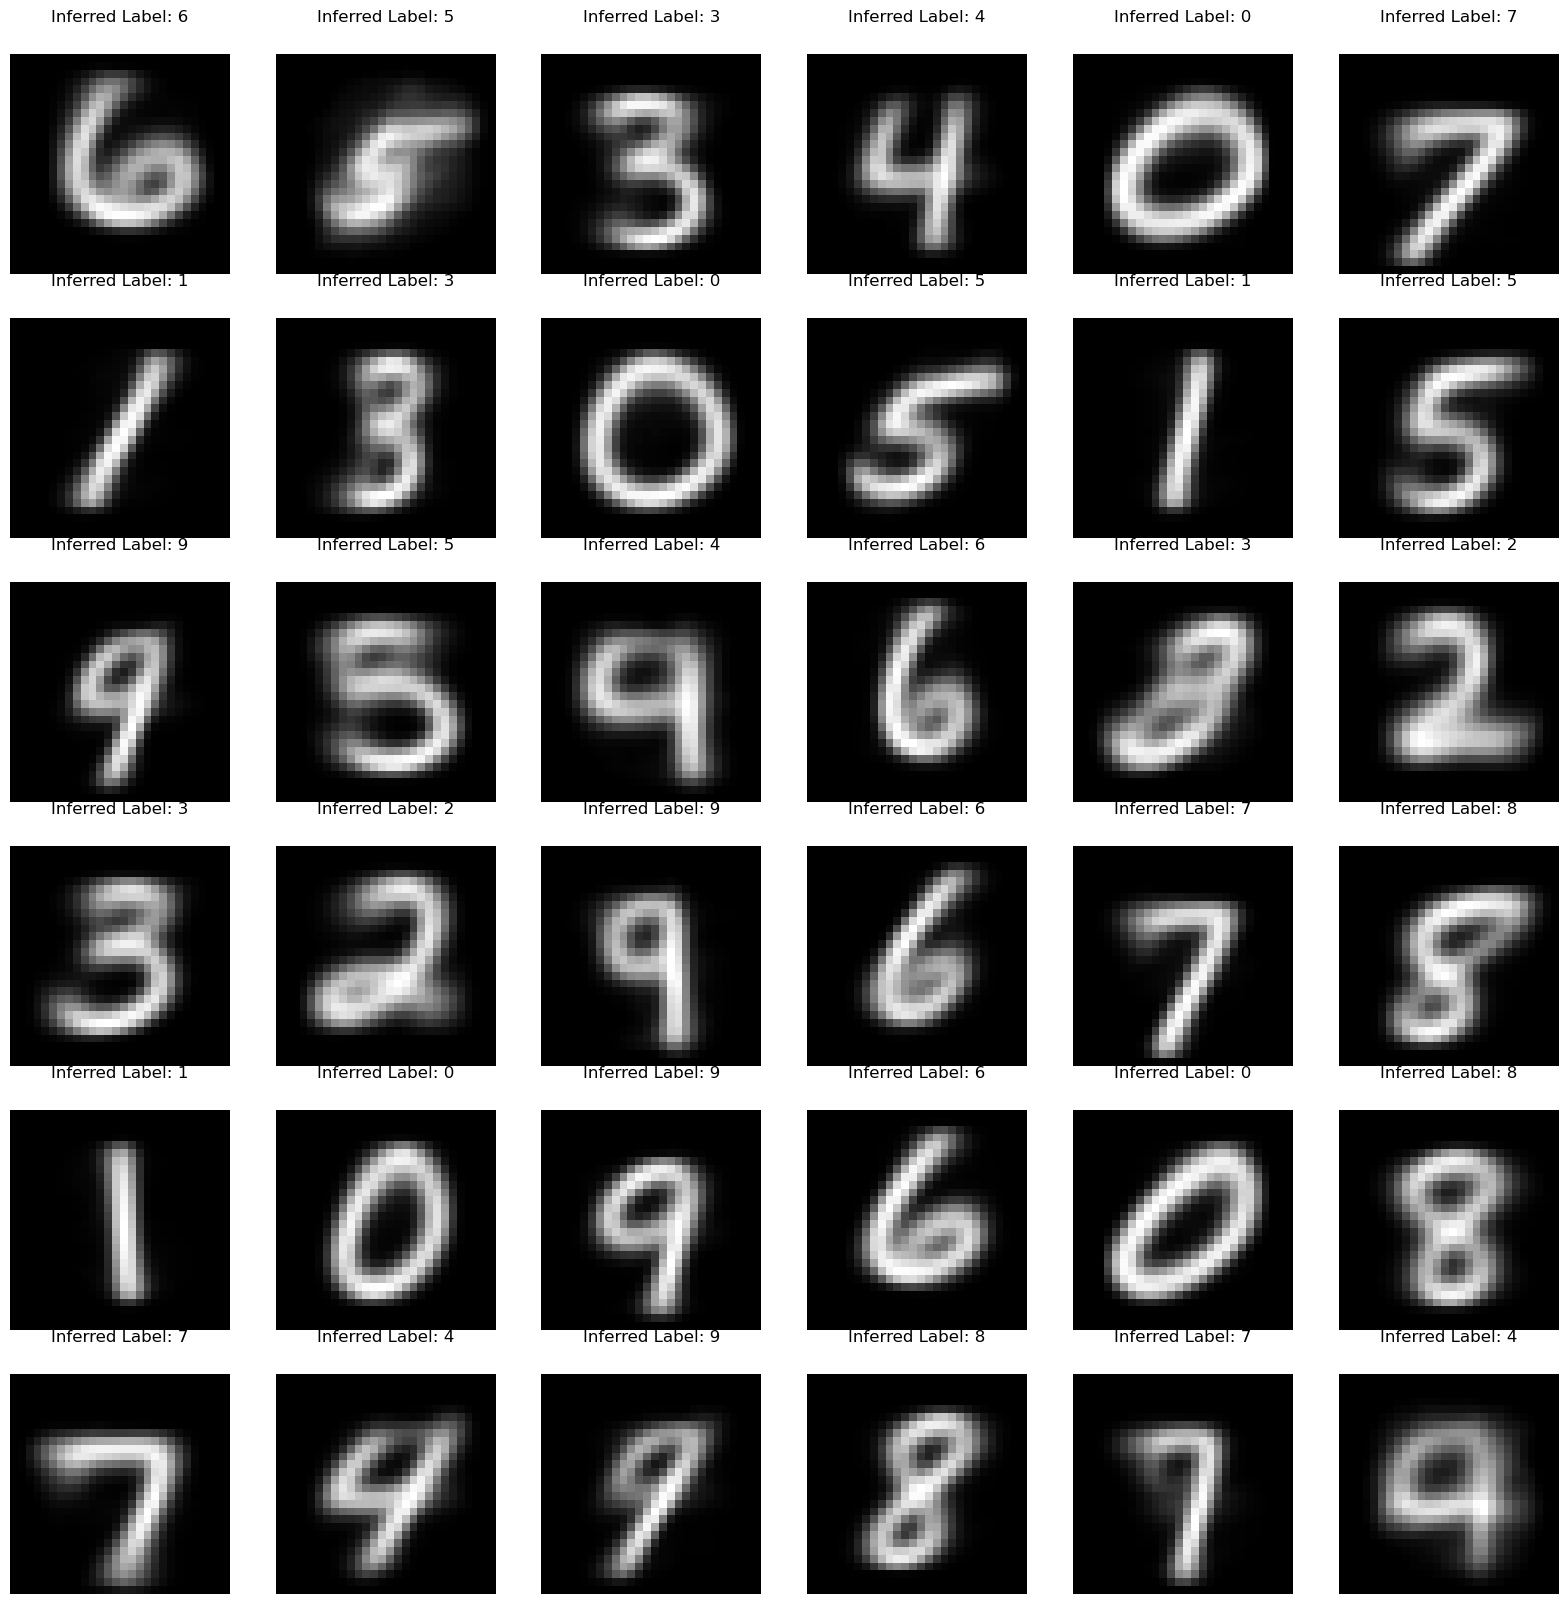

In [56]:
# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(36, 28, 28)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, Y)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
fig.show()